In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.3.0


Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


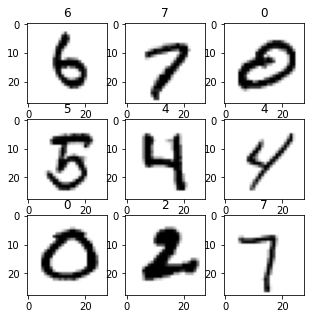

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

plt.figure(figsize=(5, 5))
for j in range(9):
    i = np.random.randint(0, 10000)
    plt.subplot(330 + 1 + j)
    plt.imshow(trainX[i], cmap='gray_r')
    plt.title(trainY[i])
plt.show()

In [4]:
#Ten classes
set(trainY)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [5]:
trainX = [(image-127.5)/127.5 for image in trainX]
testX = [(image-127.5)/127.5 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Generator Model

In [6]:
random_input = tensorflow.keras.layers.Input(shape = 50)
control_input = tensorflow.keras.layers.Input(shape = 10)

x1 = tensorflow.keras.layers.Dense(64)(random_input)

#Class Input
x2 = tensorflow.keras.layers.Dense(32)(control_input)

x = tensorflow.keras.layers.Concatenate()([x1, x2])

x = tensorflow.keras.layers.Dense(5*5*64)(x)
x = tensorflow.keras.layers.Activation('swish')(x)

x = tensorflow.keras.layers.Reshape((5, 5, 64))(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(8,8))(x)
generated_image = tensorflow.keras.layers.Activation('tanh')(x)

generator_network = tensorflow.keras.models.Model(inputs=[random_input, control_input], outputs=generated_image)
generator_network.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           3264        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           352         input_2[0][0]                    
_______________________________________________________________________________________

# Discriminator

In [7]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3))(image_input)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=2)(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

x = tensorflow.keras.layers.Flatten()(x)

x = tensorflow.keras.layers.Dense(128)(x)
x = tensorflow.keras.layers.BatchNormalization()(x)

features = tensorflow.keras.layers.Activation('swish')(x)

d_out = tensorflow.keras.layers.Dense(1)(features)
real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(d_out)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)

info = tensorflow.keras.layers.Dense(128)(features)
info = tensorflow.keras.layers.Activation('swish')(info)
info = tensorflow.keras.layers.BatchNormalization()(info)

info = tensorflow.keras.layers.Dense(10)(info)
info_output = tensorflow.keras.layers.Activation('softmax')(info)

info_network = tensorflow.keras.models.Model(inputs=image_input, outputs=info_output)

print (discriminator_network.summary())
print (info_network.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 128)       1280      
_________________________________________________________________
activation_5 (Activation)    (None, 26, 26, 128)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       409728    
_________________________________________________________________
activation_6 (Activation)    (None, 11, 11, 128)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 11, 11, 128)      

In [8]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

info_network.compile(loss='categorical_crossentropy', optimizer=adam_optimizer)

# GAN

In [9]:
discriminator_network.trainable=False

g_output = generator_network([random_input, control_input])

d_output = discriminator_network(g_output)
info_output = info_network(g_output)

info_gan_model = tensorflow.keras.models.Model(inputs = [random_input, control_input], outputs=[d_output, info_output])
info_gan_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 28, 28, 1)    1979361     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 1)            1642881     functional_1[0][0]    

# Compiling InfoGAN

In [12]:
loss_weights = [2, 1]
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5)
info_gan_model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=adam_optimizer, loss_weights=loss_weights)

# Define Data Generators

In [13]:
indices = [i for i in range(0, len(trainX))]

def encode_control_input(value):
    x = np.zeros((10))
    x[value]=1
    return x

def decode_control_input(value):
    return np.where(value==1)[0][0]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batches = np.reshape(random_values, (batch_size, noise_size))
    control_inputs = []
    for i in range(batch_size):
        control_input = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], size=1)
        control_inputs.append(encode_control_input(control_input))
    control_inputs = np.array(control_inputs)
    return random_noise_batches, control_inputs

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batches, control_inputs= get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch([random_noise_batches, control_inputs])
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    random_noise_batches, control_inputs= get_random_noise(10, noise_size) 
    fake_samples = generator_network.predict_on_batch([random_noise_batches, control_inputs])
    # for i in range(0, len(fake_samples)):
    #     plt.imshow(fake_samples[i,:,:,-1], cmap='gray')
    #     plt.show()

    plt.figure(figsize=(7, 7))
    for j in range(9):
        i = j
        plt.subplot(330 + 1 + j)
        plt.imshow(fake_samples[i,:,:,-1], cmap='gray')
        plt.title(decode_control_input(control_inputs[i]))
    plt.show()
    return

# Training GAN

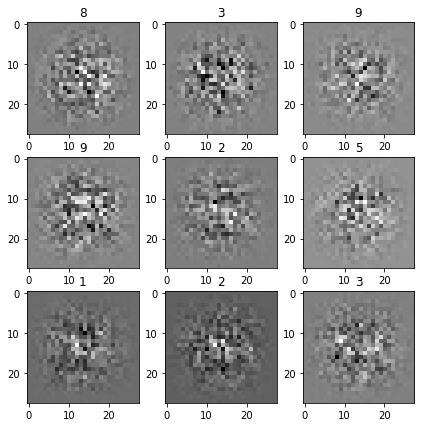

Epoch:0, Step:0, D-Loss:1.013, D-Acc:11.000, G-Loss:3.697, Info-Loss:0.693
Epoch:0, Step:50, D-Loss:0.013, D-Acc:100.000, G-Loss:2.272, Info-Loss:1.118
Epoch:0, Step:100, D-Loss:0.005, D-Acc:100.000, G-Loss:3.412, Info-Loss:1.701
Epoch:0, Step:150, D-Loss:0.004, D-Acc:100.000, G-Loss:3.411, Info-Loss:1.702
Epoch:0, Step:200, D-Loss:0.200, D-Acc:95.000, G-Loss:5.978, Info-Loss:2.890
Epoch:0, Step:250, D-Loss:0.011, D-Acc:100.000, G-Loss:0.064, Info-Loss:0.025
Epoch:0, Step:300, D-Loss:0.008, D-Acc:100.000, G-Loss:0.020, Info-Loss:0.008
Epoch:0, Step:350, D-Loss:0.006, D-Acc:100.000, G-Loss:0.017, Info-Loss:0.007
Epoch:0, Step:400, D-Loss:0.005, D-Acc:100.000, G-Loss:0.021, Info-Loss:0.009
Epoch:0, Step:450, D-Loss:0.005, D-Acc:100.000, G-Loss:0.101, Info-Loss:0.048
Epoch:1, Step:0, D-Loss:0.020, D-Acc:99.000, G-Loss:0.176, Info-Loss:0.006
Epoch:1, Step:50, D-Loss:0.004, D-Acc:100.000, G-Loss:0.018, Info-Loss:0.008
Epoch:1, Step:100, D-Loss:0.003, D-Acc:100.000, G-Loss:0.038, Info-Loss:0

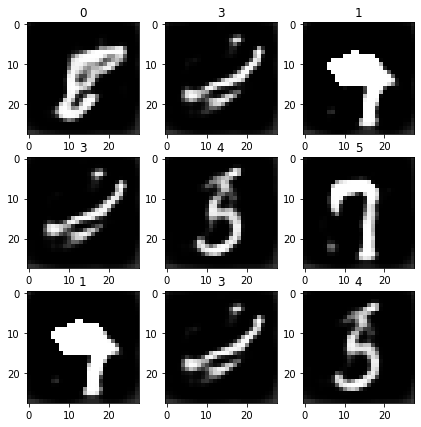

Epoch:10, Step:0, D-Loss:0.051, D-Acc:98.000, G-Loss:1.386, Info-Loss:0.668
Epoch:10, Step:50, D-Loss:0.007, D-Acc:100.000, G-Loss:1.459, Info-Loss:0.714
Epoch:10, Step:100, D-Loss:0.004, D-Acc:100.000, G-Loss:1.858, Info-Loss:0.912
Epoch:10, Step:150, D-Loss:0.002, D-Acc:100.000, G-Loss:1.011, Info-Loss:0.501
Epoch:10, Step:200, D-Loss:0.011, D-Acc:100.000, G-Loss:4.970, Info-Loss:2.436
Epoch:10, Step:250, D-Loss:0.061, D-Acc:99.000, G-Loss:3.163, Info-Loss:1.505
Epoch:10, Step:300, D-Loss:0.028, D-Acc:99.000, G-Loss:0.921, Info-Loss:0.393
Epoch:10, Step:350, D-Loss:0.003, D-Acc:100.000, G-Loss:0.372, Info-Loss:0.182
Epoch:10, Step:400, D-Loss:0.077, D-Acc:97.000, G-Loss:6.272, Info-Loss:3.021
Epoch:10, Step:450, D-Loss:0.058, D-Acc:99.000, G-Loss:7.242, Info-Loss:3.389
Epoch:11, Step:0, D-Loss:0.003, D-Acc:100.000, G-Loss:0.431, Info-Loss:0.192
Epoch:11, Step:50, D-Loss:0.006, D-Acc:100.000, G-Loss:9.640, Info-Loss:4.762
Epoch:11, Step:100, D-Loss:0.060, D-Acc:99.000, G-Loss:2.502, I

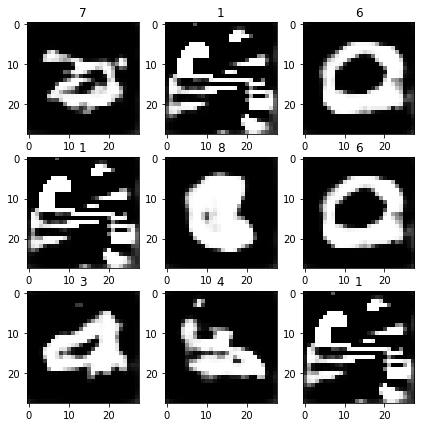

Epoch:20, Step:0, D-Loss:0.012, D-Acc:100.000, G-Loss:7.010, Info-Loss:3.472
Epoch:20, Step:50, D-Loss:0.045, D-Acc:99.000, G-Loss:3.205, Info-Loss:1.560
Epoch:20, Step:100, D-Loss:0.003, D-Acc:100.000, G-Loss:1.040, Info-Loss:0.515
Epoch:20, Step:150, D-Loss:0.002, D-Acc:100.000, G-Loss:1.844, Info-Loss:0.920
Epoch:20, Step:200, D-Loss:0.001, D-Acc:100.000, G-Loss:0.574, Info-Loss:0.284
Epoch:20, Step:250, D-Loss:0.001, D-Acc:100.000, G-Loss:0.255, Info-Loss:0.126
Epoch:20, Step:300, D-Loss:0.001, D-Acc:100.000, G-Loss:0.201, Info-Loss:0.099
Epoch:20, Step:350, D-Loss:0.003, D-Acc:100.000, G-Loss:2.442, Info-Loss:1.199
Epoch:20, Step:400, D-Loss:0.009, D-Acc:100.000, G-Loss:1.095, Info-Loss:0.539
Epoch:20, Step:450, D-Loss:0.002, D-Acc:100.000, G-Loss:0.219, Info-Loss:0.106
Epoch:21, Step:0, D-Loss:0.001, D-Acc:100.000, G-Loss:0.308, Info-Loss:0.152
Epoch:21, Step:50, D-Loss:0.004, D-Acc:100.000, G-Loss:1.320, Info-Loss:0.658
Epoch:21, Step:100, D-Loss:0.001, D-Acc:100.000, G-Loss:7.4

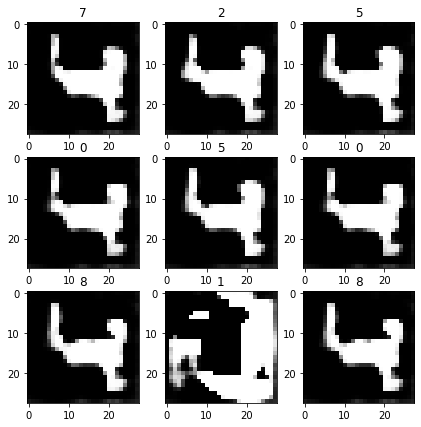

Epoch:30, Step:0, D-Loss:0.000, D-Acc:100.000, G-Loss:0.786, Info-Loss:0.366
Epoch:30, Step:50, D-Loss:0.001, D-Acc:100.000, G-Loss:4.610, Info-Loss:1.902
Epoch:30, Step:100, D-Loss:0.001, D-Acc:100.000, G-Loss:3.622, Info-Loss:1.773
Epoch:30, Step:150, D-Loss:0.043, D-Acc:99.000, G-Loss:1.959, Info-Loss:0.914
Epoch:30, Step:200, D-Loss:0.004, D-Acc:100.000, G-Loss:1.793, Info-Loss:0.819
Epoch:30, Step:250, D-Loss:0.002, D-Acc:100.000, G-Loss:1.077, Info-Loss:0.449
Epoch:30, Step:300, D-Loss:0.000, D-Acc:100.000, G-Loss:1.587, Info-Loss:0.657
Epoch:30, Step:350, D-Loss:0.000, D-Acc:100.000, G-Loss:3.724, Info-Loss:1.836
Epoch:30, Step:400, D-Loss:0.001, D-Acc:100.000, G-Loss:9.185, Info-Loss:4.387
Epoch:30, Step:450, D-Loss:0.000, D-Acc:100.000, G-Loss:0.115, Info-Loss:0.048
Epoch:31, Step:0, D-Loss:0.001, D-Acc:100.000, G-Loss:0.397, Info-Loss:0.185
Epoch:31, Step:50, D-Loss:0.000, D-Acc:100.000, G-Loss:0.894, Info-Loss:0.439
Epoch:31, Step:100, D-Loss:0.000, D-Acc:100.000, G-Loss:0.9

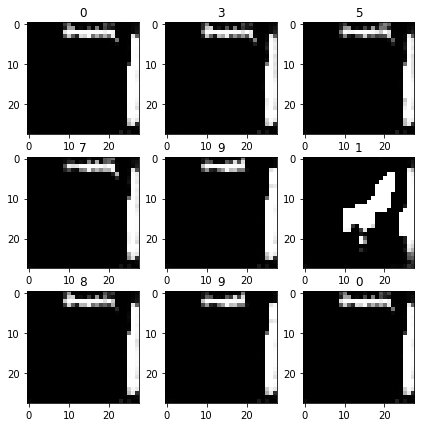

Epoch:40, Step:0, D-Loss:0.000, D-Acc:100.000, G-Loss:18.663, Info-Loss:9.321
Epoch:40, Step:50, D-Loss:0.000, D-Acc:100.000, G-Loss:19.804, Info-Loss:9.883
Epoch:40, Step:100, D-Loss:0.000, D-Acc:100.000, G-Loss:10.113, Info-Loss:4.984
Epoch:40, Step:150, D-Loss:0.000, D-Acc:100.000, G-Loss:1.926, Info-Loss:0.957
Epoch:40, Step:200, D-Loss:0.000, D-Acc:100.000, G-Loss:0.042, Info-Loss:0.020
Epoch:40, Step:250, D-Loss:0.000, D-Acc:100.000, G-Loss:0.073, Info-Loss:0.035
Epoch:40, Step:300, D-Loss:0.000, D-Acc:100.000, G-Loss:0.198, Info-Loss:0.092
Epoch:40, Step:350, D-Loss:0.000, D-Acc:100.000, G-Loss:0.509, Info-Loss:0.253
Epoch:40, Step:400, D-Loss:0.001, D-Acc:100.000, G-Loss:1.436, Info-Loss:0.712
Epoch:40, Step:450, D-Loss:0.000, D-Acc:100.000, G-Loss:0.033, Info-Loss:0.017
Epoch:41, Step:0, D-Loss:0.000, D-Acc:100.000, G-Loss:0.018, Info-Loss:0.008
Epoch:41, Step:50, D-Loss:0.000, D-Acc:100.000, G-Loss:0.051, Info-Loss:0.017
Epoch:41, Step:100, D-Loss:0.000, D-Acc:100.000, G-Loss

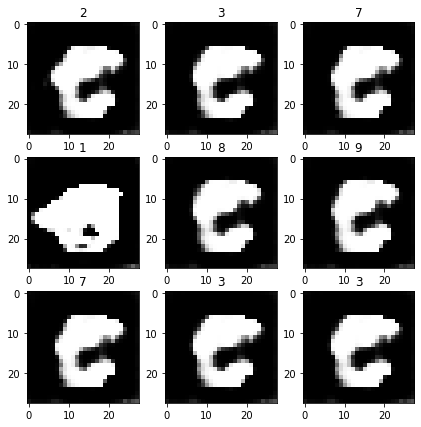

Epoch:50, Step:0, D-Loss:0.000, D-Acc:100.000, G-Loss:1.526, Info-Loss:0.673
Epoch:50, Step:50, D-Loss:0.000, D-Acc:100.000, G-Loss:0.703, Info-Loss:0.338
Epoch:50, Step:100, D-Loss:0.001, D-Acc:100.000, G-Loss:1.836, Info-Loss:0.915
Epoch:50, Step:150, D-Loss:0.001, D-Acc:100.000, G-Loss:1.457, Info-Loss:0.368
Epoch:50, Step:200, D-Loss:0.009, D-Acc:100.000, G-Loss:4.877, Info-Loss:0.311
Epoch:50, Step:250, D-Loss:0.000, D-Acc:100.000, G-Loss:0.109, Info-Loss:0.051
Epoch:50, Step:300, D-Loss:0.004, D-Acc:100.000, G-Loss:14.128, Info-Loss:6.531
Epoch:50, Step:350, D-Loss:0.000, D-Acc:100.000, G-Loss:0.018, Info-Loss:0.000
Epoch:50, Step:400, D-Loss:0.000, D-Acc:100.000, G-Loss:0.019, Info-Loss:0.003
Epoch:50, Step:450, D-Loss:0.001, D-Acc:100.000, G-Loss:2.840, Info-Loss:1.322
Epoch:51, Step:0, D-Loss:0.000, D-Acc:100.000, G-Loss:0.378, Info-Loss:0.145
Epoch:51, Step:50, D-Loss:0.000, D-Acc:100.000, G-Loss:2.646, Info-Loss:1.262
Epoch:51, Step:100, D-Loss:0.000, D-Acc:100.000, G-Loss:0

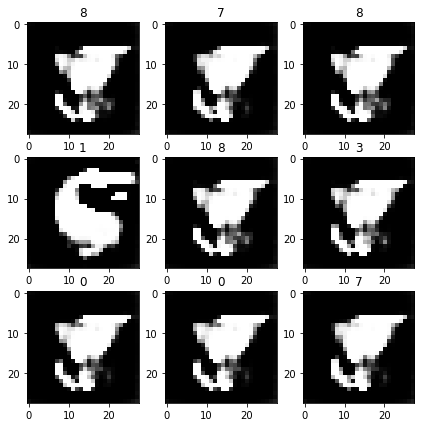

Epoch:60, Step:0, D-Loss:0.000, D-Acc:100.000, G-Loss:0.010, Info-Loss:0.004
Epoch:60, Step:50, D-Loss:0.000, D-Acc:100.000, G-Loss:0.722, Info-Loss:0.358
Epoch:60, Step:100, D-Loss:0.000, D-Acc:100.000, G-Loss:5.042, Info-Loss:2.511
Epoch:60, Step:150, D-Loss:0.000, D-Acc:100.000, G-Loss:2.284, Info-Loss:1.138
Epoch:60, Step:200, D-Loss:0.000, D-Acc:100.000, G-Loss:4.054, Info-Loss:0.981
Epoch:60, Step:250, D-Loss:0.000, D-Acc:100.000, G-Loss:2.300, Info-Loss:1.148
Epoch:60, Step:300, D-Loss:0.000, D-Acc:100.000, G-Loss:0.046, Info-Loss:0.010
Epoch:60, Step:350, D-Loss:0.000, D-Acc:100.000, G-Loss:0.399, Info-Loss:0.196
Epoch:60, Step:400, D-Loss:0.000, D-Acc:100.000, G-Loss:0.892, Info-Loss:0.443
Epoch:60, Step:450, D-Loss:0.000, D-Acc:100.000, G-Loss:0.663, Info-Loss:0.010
Epoch:61, Step:0, D-Loss:0.000, D-Acc:100.000, G-Loss:0.125, Info-Loss:0.000
Epoch:61, Step:50, D-Loss:0.000, D-Acc:100.000, G-Loss:0.021, Info-Loss:0.000
Epoch:61, Step:100, D-Loss:0.000, D-Acc:100.000, G-Loss:0.

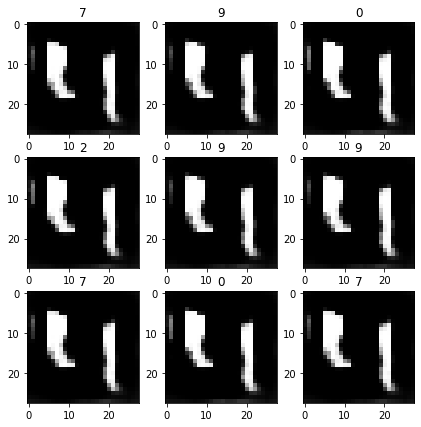

Epoch:70, Step:0, D-Loss:0.000, D-Acc:100.000, G-Loss:2.808, Info-Loss:1.388
Epoch:70, Step:50, D-Loss:0.000, D-Acc:100.000, G-Loss:1.517, Info-Loss:0.749
Epoch:70, Step:100, D-Loss:0.000, D-Acc:100.000, G-Loss:0.645, Info-Loss:0.281
Epoch:70, Step:150, D-Loss:0.000, D-Acc:100.000, G-Loss:1.141, Info-Loss:0.542
Epoch:70, Step:200, D-Loss:0.000, D-Acc:100.000, G-Loss:0.053, Info-Loss:0.017
Epoch:70, Step:250, D-Loss:0.000, D-Acc:100.000, G-Loss:0.240, Info-Loss:0.119
Epoch:70, Step:300, D-Loss:0.000, D-Acc:100.000, G-Loss:1.068, Info-Loss:0.531
Epoch:70, Step:350, D-Loss:0.000, D-Acc:100.000, G-Loss:1.151, Info-Loss:0.567
Epoch:70, Step:400, D-Loss:0.000, D-Acc:100.000, G-Loss:0.470, Info-Loss:0.234
Epoch:70, Step:450, D-Loss:0.000, D-Acc:100.000, G-Loss:1.098, Info-Loss:0.549
Epoch:71, Step:0, D-Loss:0.000, D-Acc:100.000, G-Loss:1.571, Info-Loss:0.758
Epoch:71, Step:50, D-Loss:0.000, D-Acc:100.000, G-Loss:0.009, Info-Loss:0.004
Epoch:71, Step:100, D-Loss:0.000, D-Acc:100.000, G-Loss:0.

KeyboardInterrupt: ignored

In [ ]:
epochs = 500
batch_size = 100
steps = 500
noise_size = 50

for i in range(0, epochs):
    if (i%10 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_samples = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_samples, output_labels)
        
        noise_batches, control_inputs = get_random_noise(batch_size, noise_size)
        info_gan_input = [noise_batches, control_inputs]
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        d_output = np.ones((batch_size))
        info_output = control_inputs
        info_gan_output = [d_output, info_output]
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = info_gan_model.train_on_batch(info_gan_input, info_gan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f, Info-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g[0], loss_g[1]))
            

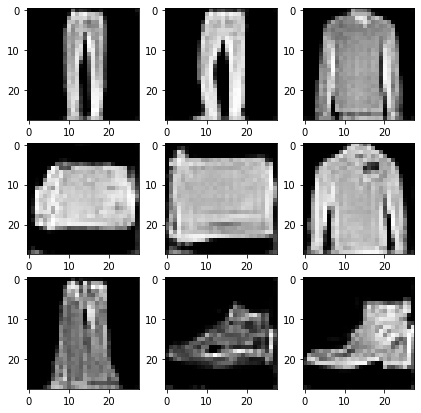

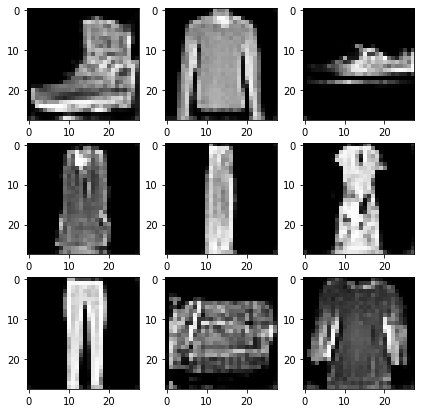

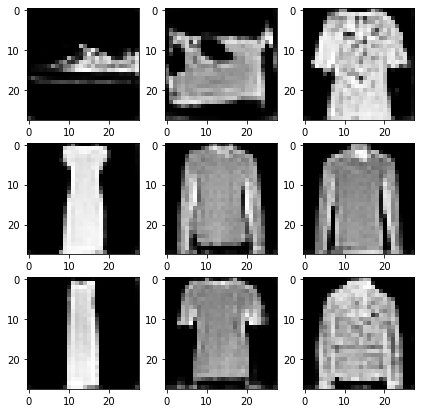

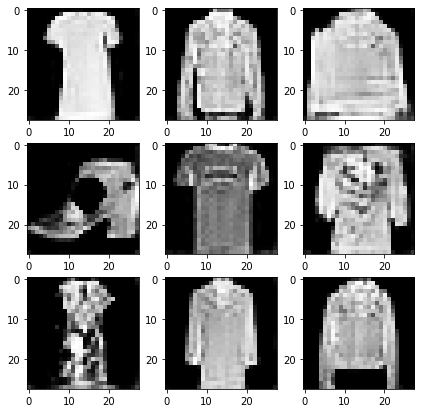

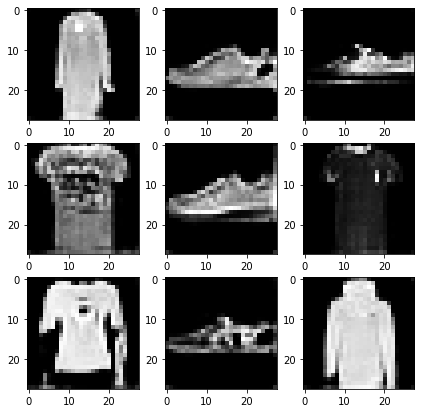

In [ ]:
#Generating Unlimited samples
for i in range(5):
    show_generator_results(generator_network)